<a href="https://colab.research.google.com/github/TanD18/Sentiment-Analysis-on-Zomato-Data/blob/main/Sentiment_Analysis_on_Zomato_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [9]:
import os, string, random, time, math
from tqdm.notebook import tqdm
import time

In [10]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
import gensim
from gensim import corpora
from gensim.corpora import Dictionary

In [12]:
from torch.cuda import is_available
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device_gpu=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
from IPython.display import clear_output

##Dataset

In [14]:
with open("/content/drive/MyDrive/working_corpus","rb") as fp:
  corpus=pickle.load(fp)

In [15]:
with open("/content/drive/MyDrive/rating_list_working","rb") as fp:
  ratings=pickle.load(fp)

In [16]:
dictionary=Dictionary(corpus)

###Glove

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-09-20 15:35:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-20 15:35:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-20 15:35:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
with open('glove.6B.100d.txt','rt') as fi:
    pretrained_glove_emb = fi.read().strip().split('\n')

In [19]:
vocab,embeddings=[],[]
for i in range(len(pretrained_glove_emb)):
    word = pretrained_glove_emb[i].split(' ')[0]
    emb = [float(val) for val in pretrained_glove_emb[i].split(' ')[1:]]
    vocab.append(word)
    embeddings.append(emb)

###Creating One-Hot-Encoded Word Vectors

In [21]:
words=[]
words.append('')
for key,value in dictionary.items():
  words.append(value)


###Representation of the Sentence to OHE vectors

###Segment the ratings into 'Positive', 'Negative' and 'Neutral' from 1-5

In [25]:
set(ratings)

{1, 2, 3, 4, 5}

In [66]:
#Finding the mean rating value from all the reviews 
np.mean(np.array(ratings)),np.median(np.array(ratings))

(3.521927466093087, 4.0)

In [31]:
sentiment=[]
for i in ratings:
  if(i<3):
    sentiment.append(0)
  elif (i==3):
    sentiment.append(1)
  else :
    sentiment.append(2)

In [35]:
X=corpus.copy()
Y=sentiment.copy()

In [37]:
np.unique(np.array(Y),return_counts=True)

(array([0, 1, 2]), array([28632, 24849, 80415]))

###Removing Excess positive sentiment




*   Current number for neg,neu,pos: 28632, 24849, 80415
*   Target number for neg,neu,pos: 28632, 24849, 30415


THUS remove 50,000 positive instances from dataset


In [38]:
count=0
target_removals=50000
for i in range(len(Y)-1,-1,-1):
 if Y[i]==2:
   X.pop(i)
   Y.pop(i)
   count+=1
   if count==target_removals:
     break

In [39]:
np.unique(np.array(Y),return_counts=True)

(array([0, 1, 2]), array([28632, 24849, 30415]))

###Split Training, Validation and Test Data

In [40]:
X_train,X_testing,Y_train,Y_testing=train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y)

In [41]:
X_val,X_test,Y_val,Y_test=train_test_split(X_testing,Y_testing,test_size=0.5,random_state=0,stratify=Y_testing)

In [42]:
len(X_train),len(X_val),len(X_test),len(Y_train),len(Y_val),len(Y_test)

(58727, 12584, 12585, 58727, 12584, 12585)

###One Hot Encoded corpus

##Model

In [44]:
class LSTM_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(LSTM_net,self).__init__()
    self.hidden=hidden_size
    self.lstm_cell=nn.LSTM(input_size,hidden_size)
    self.h2o=nn.Linear(hidden_size, output_size)
    self.softmax=nn.LogSoftmax(dim=2)

  def forward(self,input_,hidden_=None,batch_size=1):
    out,hidden=self.lstm_cell(input_,hidden_)
    output=self.h2o(hidden[0])
    output=self.softmax(output)
    return output.view(-1,3),hidden

  def init_hidden(self,batch_size=1):
    return (torch.zeros(1,batch_size,self.hidden),torch.zeros(1,batch_size,self.hidden))

In [45]:
class BiLSTM_net(nn.Module):
  def __init__(self,vocab_size, hidden_size,num_layers,embedding_dim, output_size,dropout):
    super(BiLSTM_net,self).__init__()
    self.hidden=hidden_size
    self.num_layers=num_layers
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.lstm_cell=nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,dropout=0.3,bidirectional=True,batch_first=True)
    self.dropout=nn.Dropout(dropout)
    self.h2o=nn.Linear(hidden_size*2,output_size)
    self.softmax=nn.LogSoftmax(dim=2)

  def forward(self,input_,hidden_=None,batch_size=1,rev_len=None,device='cpu'):
    emb=self.embedding(input_.to(torch.long))
    out,hidden=self.lstm_cell(emb,hidden_)
    hidden=self.dropout(torch.cat((hidden[0][-2:-1,:,:],hidden[0][-1:,:,:]),dim=2))
    output=self.h2o(hidden)
    output=self.softmax(output)
    return output.view(-1,3),hidden

  def analyse_forward(self,input_,hidden_=None,batch_size=1,rev_len=None,device='cpu'):
    seq_out=[]
    emb=self.embedding(input_.to(torch.long))
    out,hidden=self.lstm_cell(emb,hidden_)
    print("Input",input_.size())
    print("Hidden",hidden[0].size())
    print("Cell",hidden[1].size())
    print("Output",out.size())
    print(out[-1]==hidden[0])
    for i in out:
      output=self.dropout(torch.cat((i[-2:-1,:,:],i[-1:,:,:]),dim=2))
      output=self.h2o(output)
      output=self.softmax(output)
      seq_out.append(output.view(-1,3),hidden)
    return seq_out

In [46]:
# from torch._C import device
class BiGRU_net(nn.Module):
  def __init__(self,vocab_size,hidden_size,num_layers,embedding_dim,output_size,dropout):
    super(BiGRU_net,self).__init__()
    self.hidden=hidden_size
    self.num_layers=num_layers
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.bi_gru_cell=nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,dropout=0.3,bidirectional=True,batch_first=True)
    self.dropout=nn.Dropout(dropout)
    self.h2o=nn.Linear(hidden_size*2,output_size)
    self.softmax=nn.LogSoftmax(dim=2)

  def forward(self,input_,hidden_=None,batch_size=1,rev_len=None,device='cpu'):
    emb=self.embedding(input_.to(torch.long))

    out,hidden=self.bi_gru_cell(emb,hidden_)
    print("Forward hidden output",hidden.size())
    
    hidden=self.dropout(torch.cat((hidden[-2:-1,:,:],hidden[-1:,:,:]),dim=2))
    print("After Dropout hidden size",hidden.size())
    output=self.h2o(hidden)
    print("After Linear output layer",output.size())
    raise Exception("After Linear output layer",output.size())
    output=self.softmax(output)
    return output.view(-1,3),hidden

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [48]:
def dataloader(npoints,X_,Y_):
  to_ret=[]
  for i in range(npoints):
    index=np.random.randint(len(X_))
    sen,senti=X_[index],Y_[index]
    to_ret.append((sen,senti))
  return to_ret

##Batching

###Padding

In [49]:
def batched_review_rep(reviews,max_len):
  batch_size=len(reviews)
  len_word_vec=len(words)
  rep=torch.zeros(batch_size,max_len)
  for rev_index,review in enumerate(reviews):
    diff_len=max_len-len(review)
    for word_seq, word in enumerate(review):
      rep[rev_index][word_seq+diff_len]=words.index(word)
  return rep.to(torch.long)

In [50]:
def realize_batch_parse(batched_rep):
  max_len=batched_rep.shape[0]
  batched_rep=batched_rep.view((-1,batched_rep.size()[-1]))
  for review_word in batched_rep:      
    if torch.sum(review_word)==0:
      print("<pad>")
    else:
      word_index=(review_word==1).nonzero().item()
      print(words[word_index])

In [51]:
def batched_dataloader(n_points,X_,Y_,verbose=False,device='cpu'):
  len_X_=len(X_)
  reviews=[]
  ratings=[]
  reviews_len=[]
  for i in range(n_points):
    index=np.random.randint(len_X_) 
    review,rating=X_[index],Y_[index] 
    reviews_len.append(len(review))
    reviews.append(review)
    ratings.append(rating)
  
  max_len=max(reviews_len)

  reviews_rep=batched_review_rep(reviews,max_len).to(device)
  ratings_rep=torch.tensor(ratings).to(device)

  if verbose:
    print("Reviews Shape",np.array(reviews).shape)
    print("Padded Review Shape",reviews_rep.shape)
    print("\n\n")

  if verbose:
    print(reviews)
    print(realize_batch_parse(reviews_rep))
    print('--------')

  return reviews,ratings,reviews_rep,ratings_rep,torch.tensor(reviews_len)

##Evaluation

In [53]:
def eval(net,n_points,X_,Y_,device='cpu'):
  y_true=[]
  y_pred=[]
  net=net.eval().to(device)
  data=dataloader(n_points,X_,Y_)
  correct=0
  for sen, senti in data:
    batched_review=batched_review_rep([sen],len(sen))
    output,hidden=net(batched_review)
    pred=torch.argmax(output)
    y_true.append(senti)
    y_pred.append(pred)
    if(pred==senti):
      correct+=1
  confusion=confusion_matrix(y_true, y_pred)
  confusion=confusion/confusion.astype(np.float).sum(axis=1)
  df_cm=pd.DataFrame(confusion)
  sns.heatmap(df_cm, annot=True)
  plt.show()
  target_names = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_true, y_pred, target_names=target_names))
  accuracy=correct/n_points
  return accuracy

##Train

In [59]:
def train_a_batch(net,opt,loss_fn,n_points,device='cpu'):

  net.train().to(device)  #sets the mode to training
  opt.zero_grad()         #resetting all grad values to zero
  
  rev,rat,batched_input,batched_output,reviews_len=batched_dataloader(n_points,X_train,Y_train)
  output,hidden=net(batched_input,rev_len=reviews_len)

  loss=loss_fn(output,batched_output)

  loss.backward()
  opt.step()

  return loss
  

In [60]:
def train_setup(net,opt,lr=0.01,n_batches=100,batch_size=10,momentum=0.05,display_frequency=5,device='cpu',model_num='zomato A'):
  net=net.to(device)
  loss_fn=nn.NLLLoss()
  loss_plot=[]
  loss_arr=np.zeros(n_batches)

  for i in tqdm(range(n_batches),desc='Batch Completion'):
    loss_arr[i]=train_a_batch(net,opt,loss_fn,batch_size,device)
    
    if i%display_frequency==0:
      loss_plot.append(loss_arr[i])
      plt.plot(loss_plot)
      plt.show()
    
    if (i+1)%50==0:
      PATH="/content/drive/MyDrive/"+model_num+"-"+str(i)
      torch.save(net.state_dict(), PATH)
      print("model saved version : ",(i+1)/50)
  
  return loss_arr

##Training

###BiLSTM training

In [61]:
word_size=len(words)
n_hidden=256
num_layers=2
embedding_dim=100
net_BiLSTM=BiLSTM_net(word_size,n_hidden,num_layers,output_size=3,embedding_dim=embedding_dim,dropout=0.5)
loss_fn=nn.NLLLoss()

In [62]:
count=0
for index,word in enumerate(words):
  if word in vocab:
    ind=vocab.index(word)
    emb=torch.tensor(embeddings[ind])
    net_BiLSTM.embedding.weight.data[index]=emb
    count+=1

Batch Completion:   0%|          | 0/5000 [00:00<?, ?it/s]

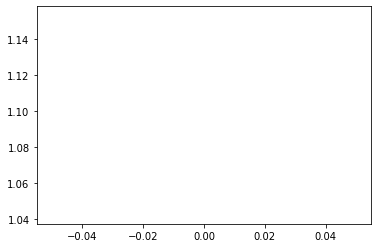

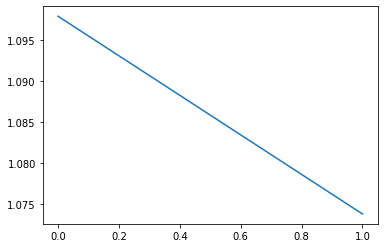

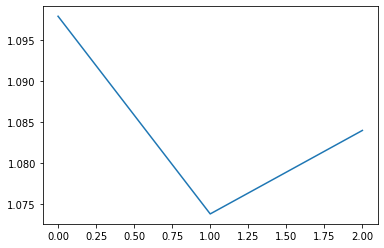

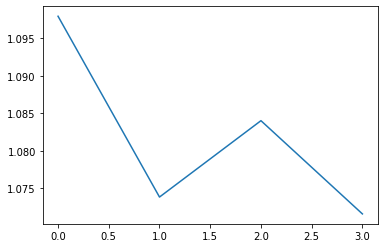

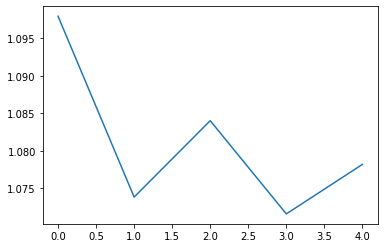

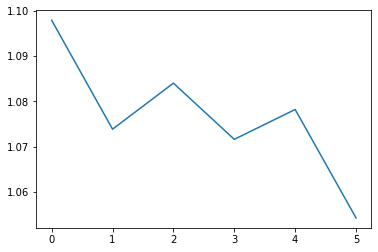

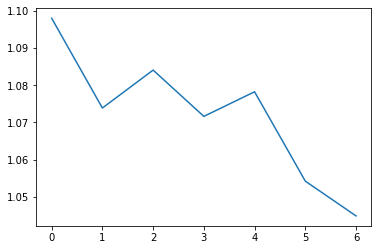

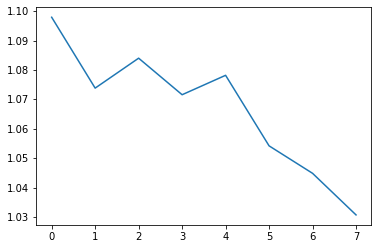

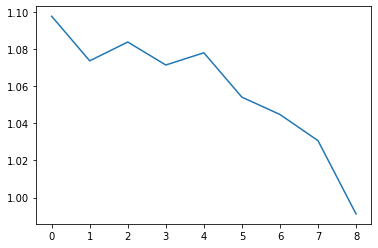

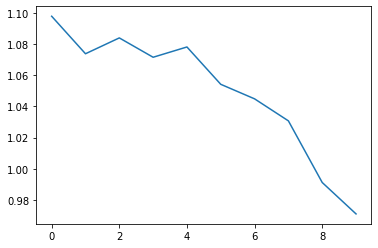

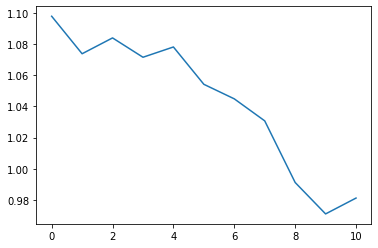

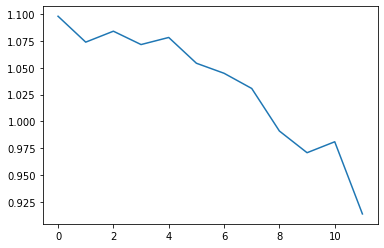

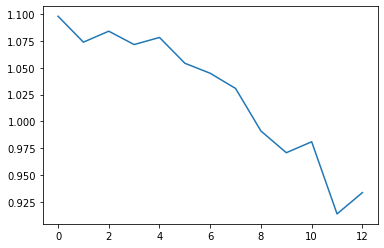

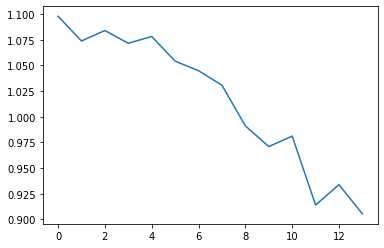

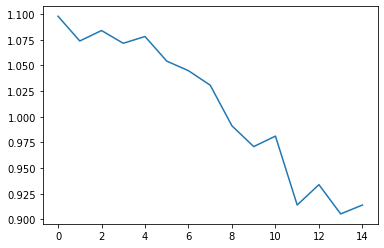

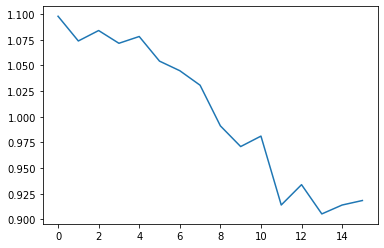

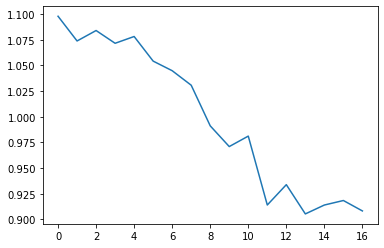

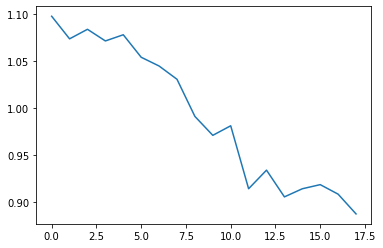

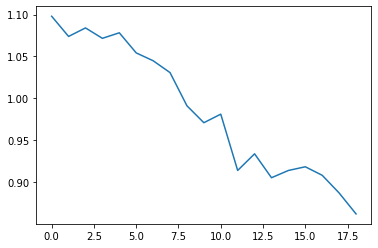

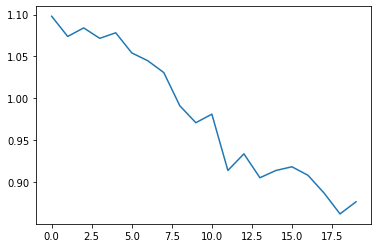

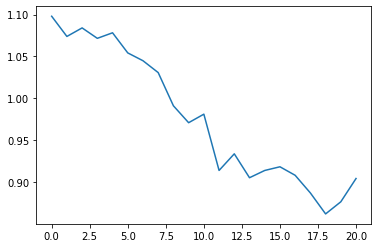

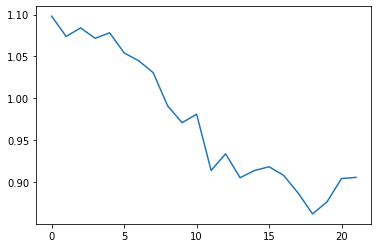

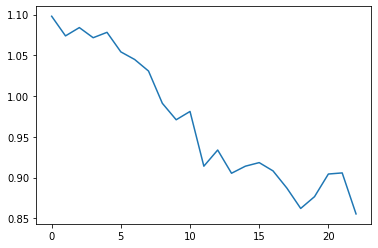

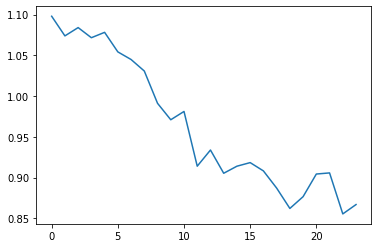

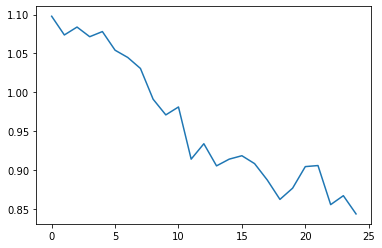

model saved version :  1.0


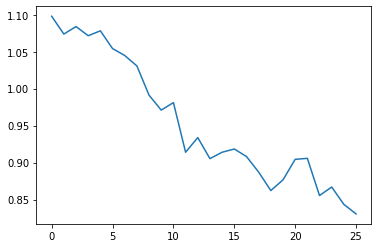

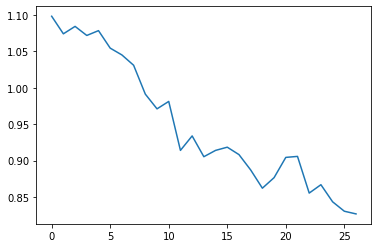

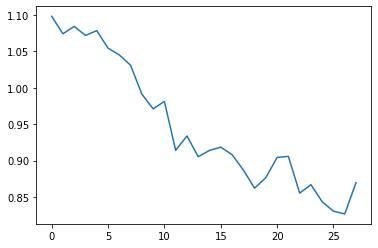

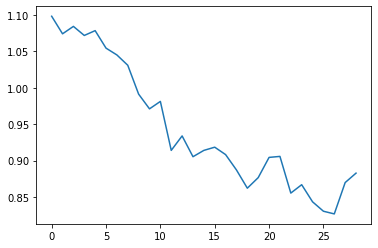

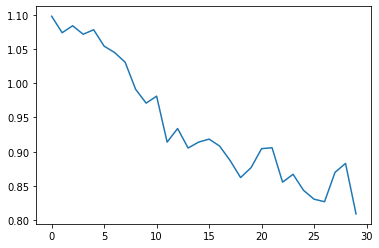

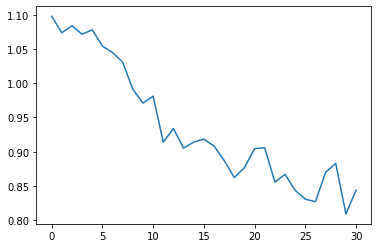

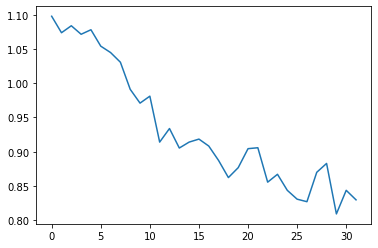

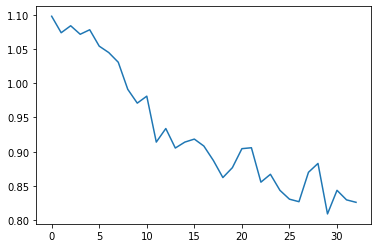

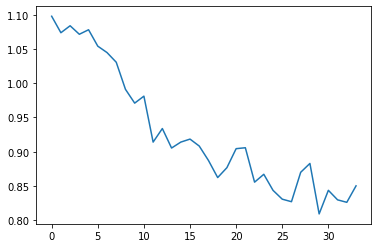

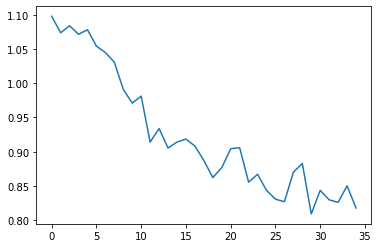

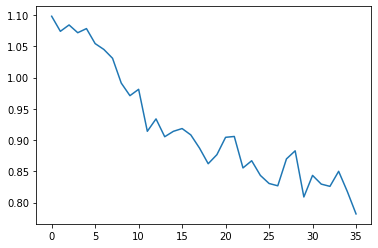

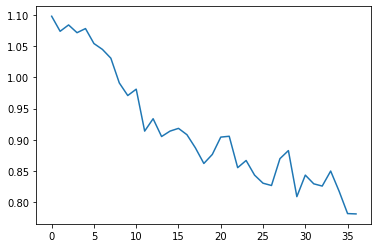

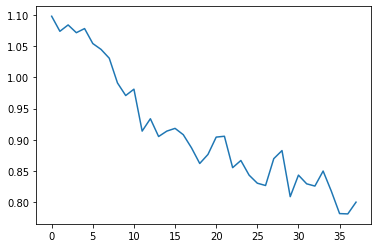

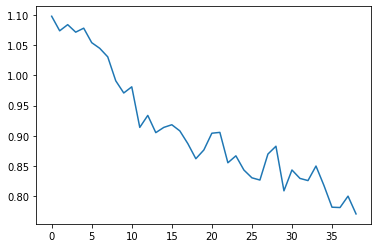

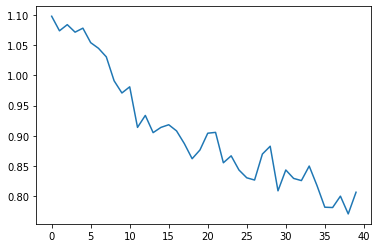

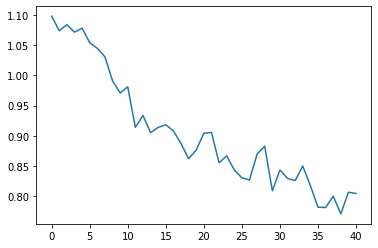

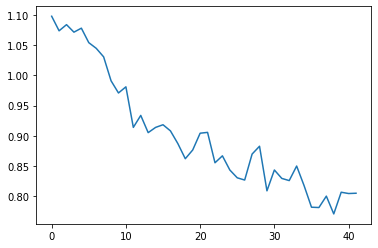

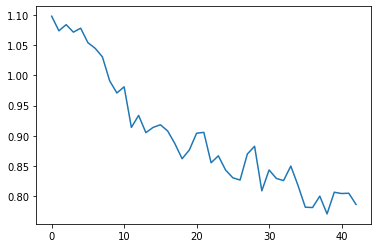

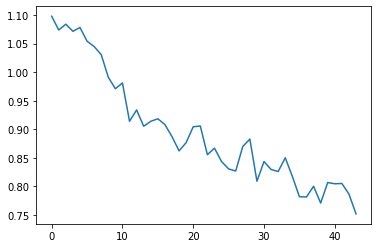

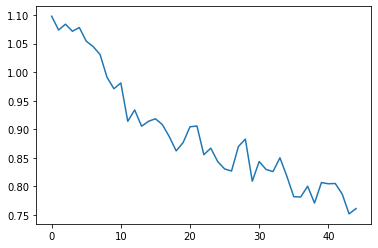

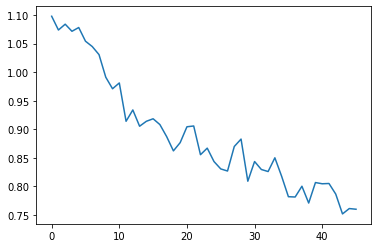

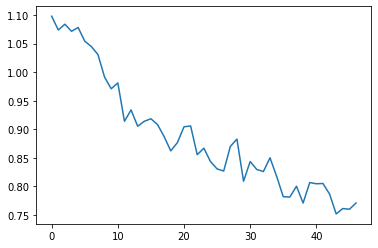

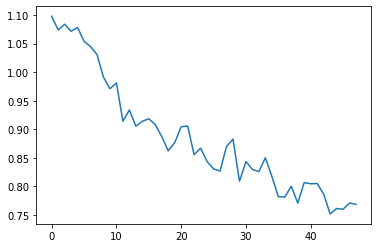

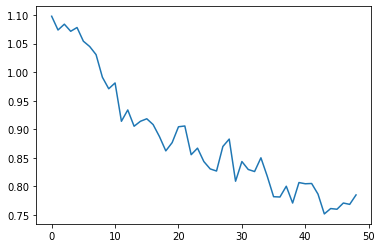

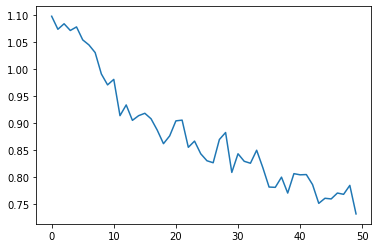

model saved version :  2.0


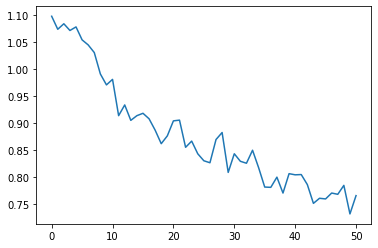

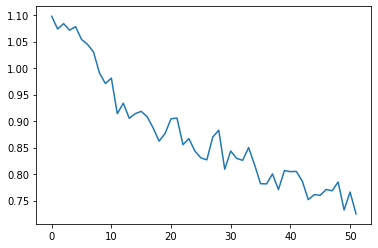

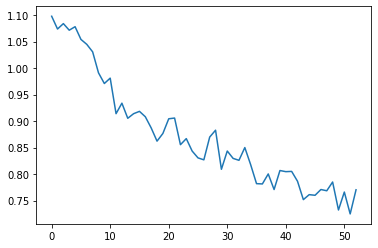

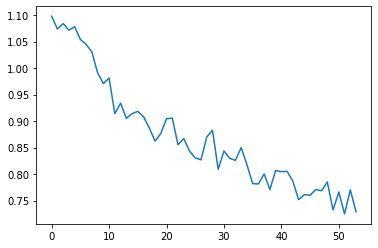

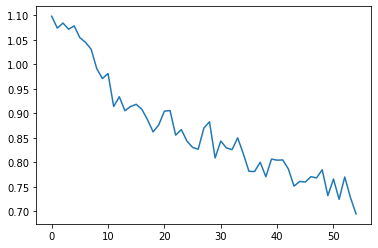

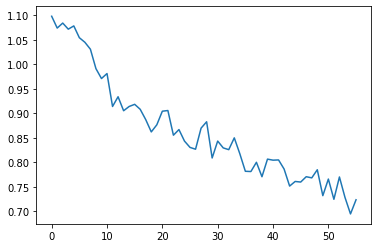

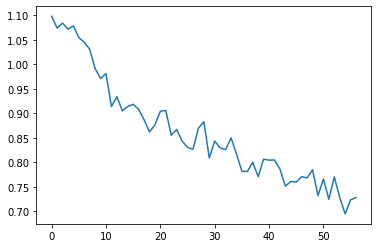

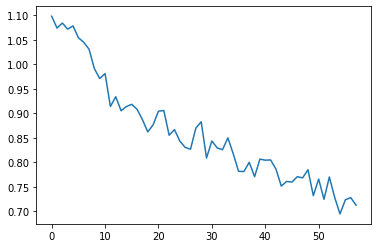

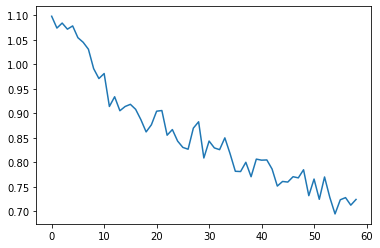

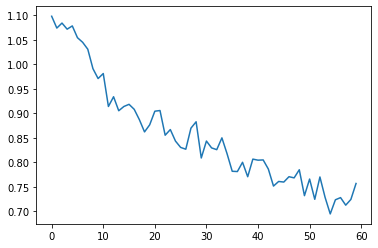

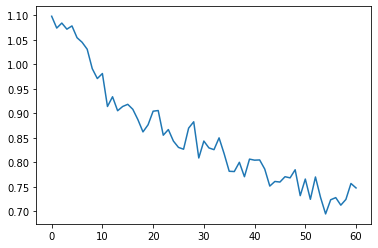

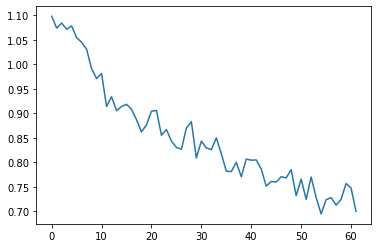

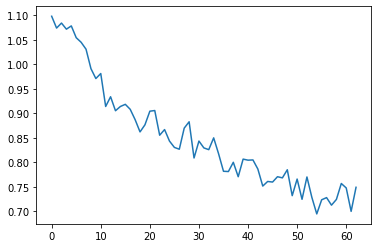

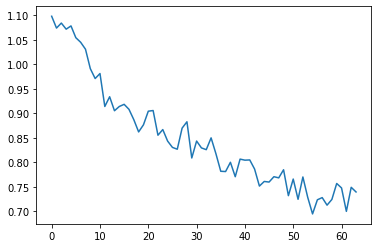

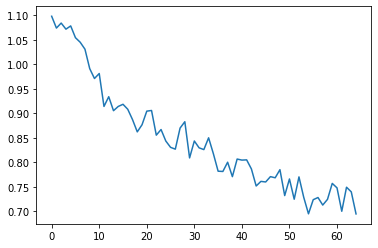

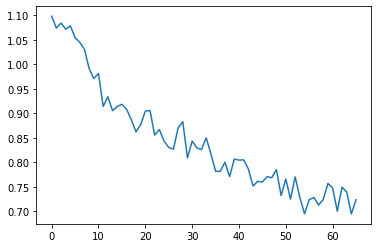

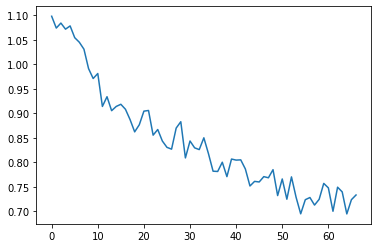

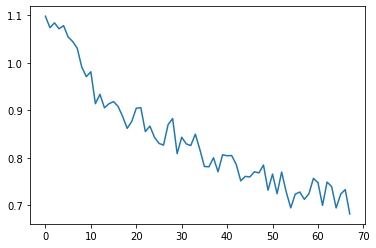

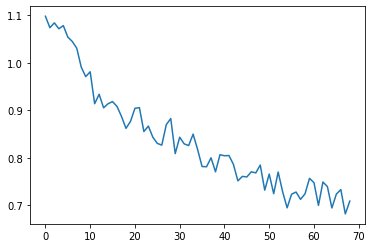

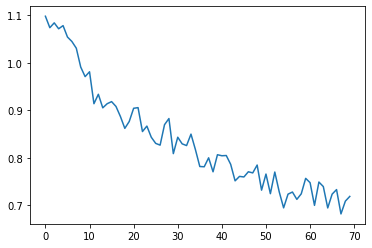

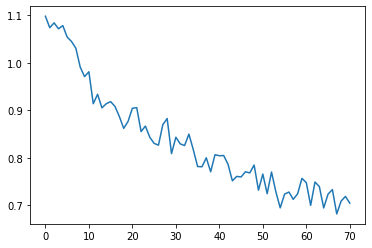

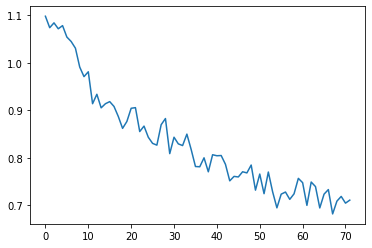

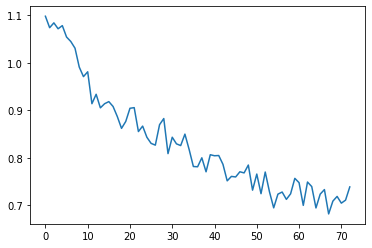

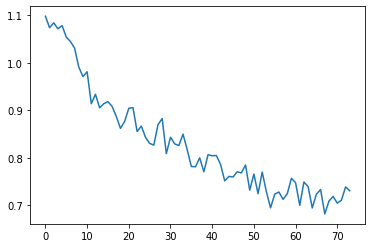

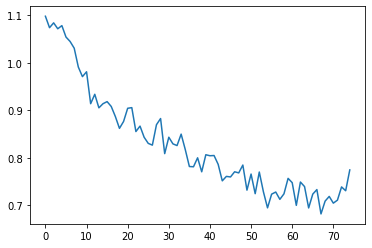

model saved version :  3.0


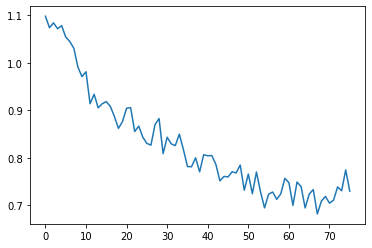

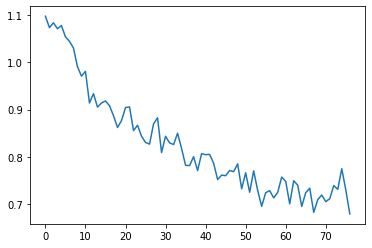

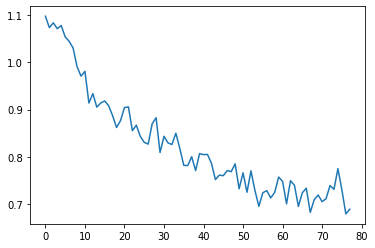

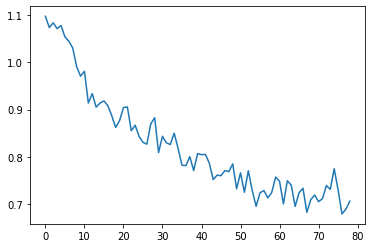

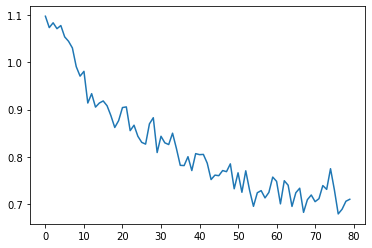

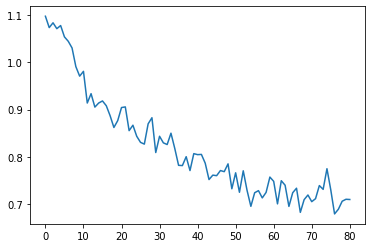

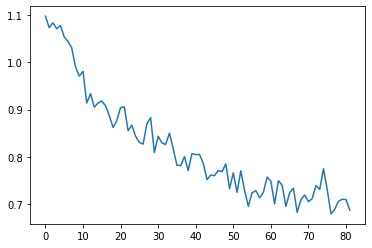

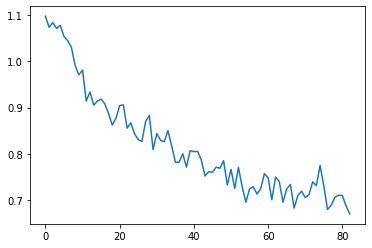

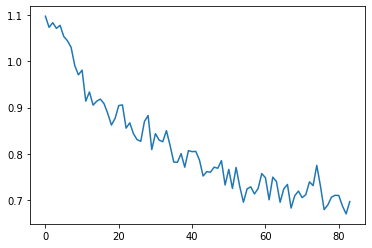

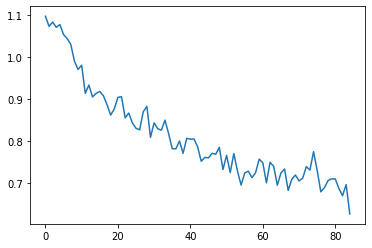

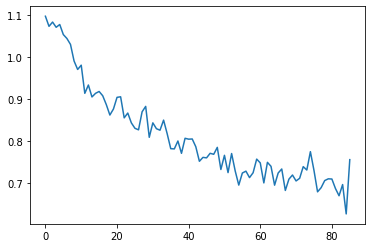

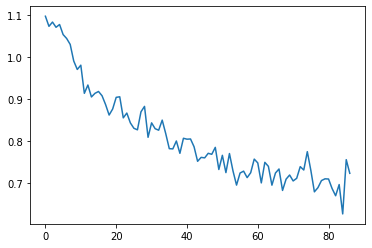

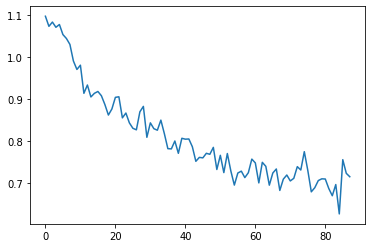

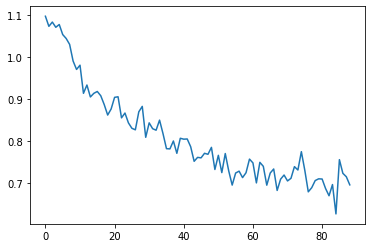

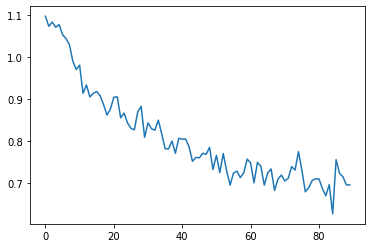

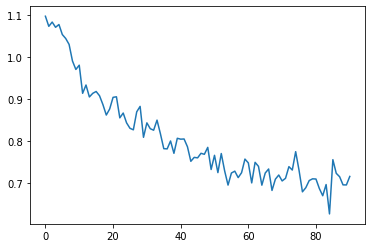

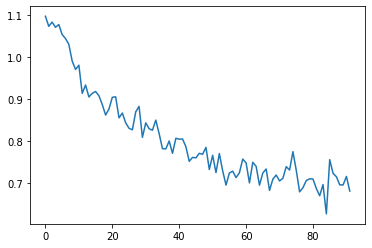

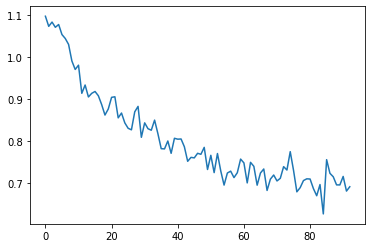

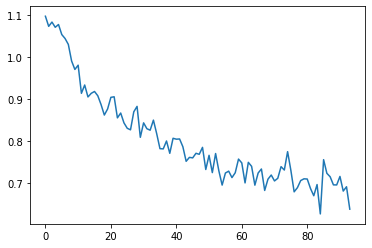

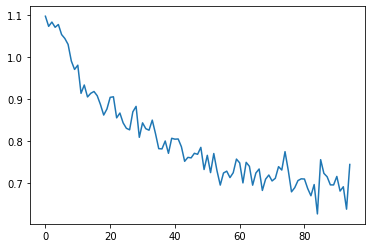

KeyboardInterrupt: ignored

In [ ]:
opt=optim.Adam(net_BiLSTM.parameters(),lr=0.001)
loss_array4=train_setup(net_BiLSTM,opt,n_batches=5000,batch_size=512,momentum=0,display_frequency=2,device=device_gpu,model_num='phase sep-1 zomato median 4')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


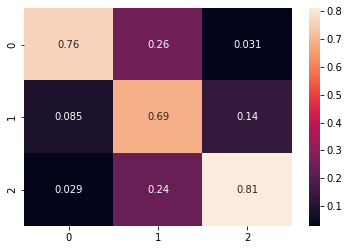

              precision    recall  f1-score   support

     class 0       0.87      0.76      0.81       343
     class 1       0.58      0.69      0.63       268
     class 2       0.83      0.81      0.82       389

    accuracy                           0.76      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.78      0.76      0.77      1000

Accuracy: 0.762


In [ ]:
accuracy=eval(net_BiLSTM,1000,X_val,Y_val,device=device_gpu)
print("Accuracy:" ,accuracy)

###Load BiLSTM model

In [ ]:
PATH="/content/drive/MyDrive/phase sep-1 zomato A-199"
net_BiLSTM.load_state_dict(torch.load(PATH))

<All keys matched successfully>